In [14]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import optim
from torch.utils.data import DataLoader

from torchvision.transforms import transforms
import torchvision.datasets as datasets

from models import U_Net
from RectifiedFlow import RectifiedFlow_Unet, train_rectified_flow_Unet

In [15]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [16]:
batch_size = 256

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])

train_dataset = datasets.MNIST(
    "./data",
    download=True,
    train=True,
    transform=transform,
)

train_dataset.data = train_dataset.data[train_dataset.targets == 6]
train_dataset.targets = train_dataset.targets[train_dataset.targets == 6]

test_dataset = datasets.MNIST(
    "./data",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

input_shape = (batch_size, 2, 32, 32)

In [17]:
v_model_1 = U_Net(input_shape=input_shape, output_channels=1)
rectified_flow_1 = RectifiedFlow_Unet(v_model_1, device)

In [18]:
optimizer_1 = torch.optim.Adam(rectified_flow_1.v_model.parameters(), lr=5e-3)
scheduler_1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_1, factor=0.8, patience=80, verbose=True)

In [19]:
rectified_flow_1 = train_rectified_flow_Unet(rectified_flow_1, optimizer_1, scheduler_1, train_dataloader, device, epochs=40)

Epoch 00537: reducing learning rate of group 0 to 4.0000e-03.
Epoch 00757: reducing learning rate of group 0 to 3.2000e-03.
Epoch 00838: reducing learning rate of group 0 to 2.5600e-03.


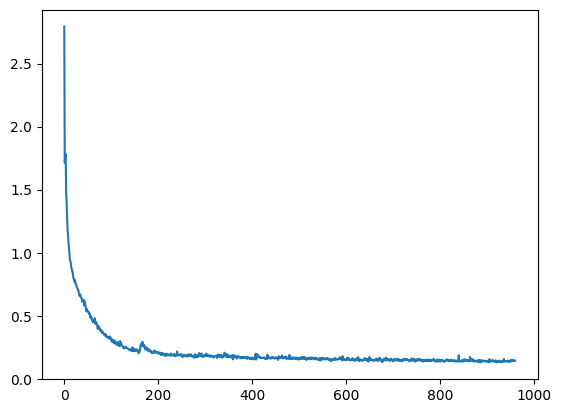

In [20]:
plt.plot(rectified_flow_1.loss_curve)
plt.show()

In [21]:
torch.save(rectified_flow_1, "./models/MNIST/MNIST_6_Unet_flow1.pth")

In [22]:
rectified_flow_1 = torch.load("./models/MNIST/MNIST_6_Unet_flow1.pth")

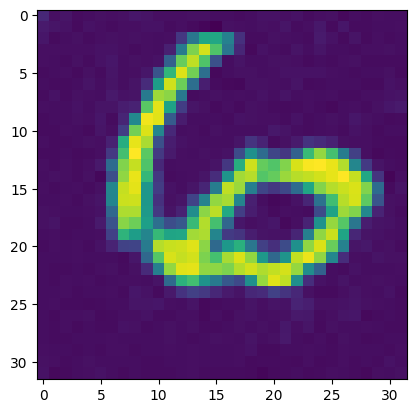

In [25]:
rectified_flow_1.v_model.eval()
img_init = torch.randn(20,1,32,32).to(device)

img = rectified_flow_1.sample_ode(img_init, num_steps=100)

plt.imshow(img[-1][0, 0].detach().cpu().numpy())
plt.show()

[]

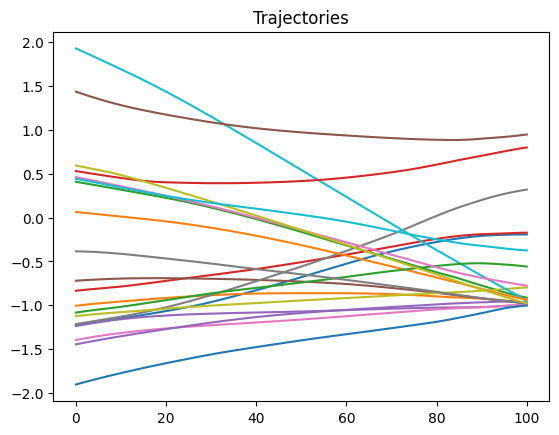

In [26]:
s = torch.zeros(20,len(img),1,32,32)
for i in range(len(img)):
    s[:,i] = img[i]
for i in range(20):
    plt.plot(s[i,:,0,15,15].cpu().numpy())
plt.title("Trajectories")
plt.plot()

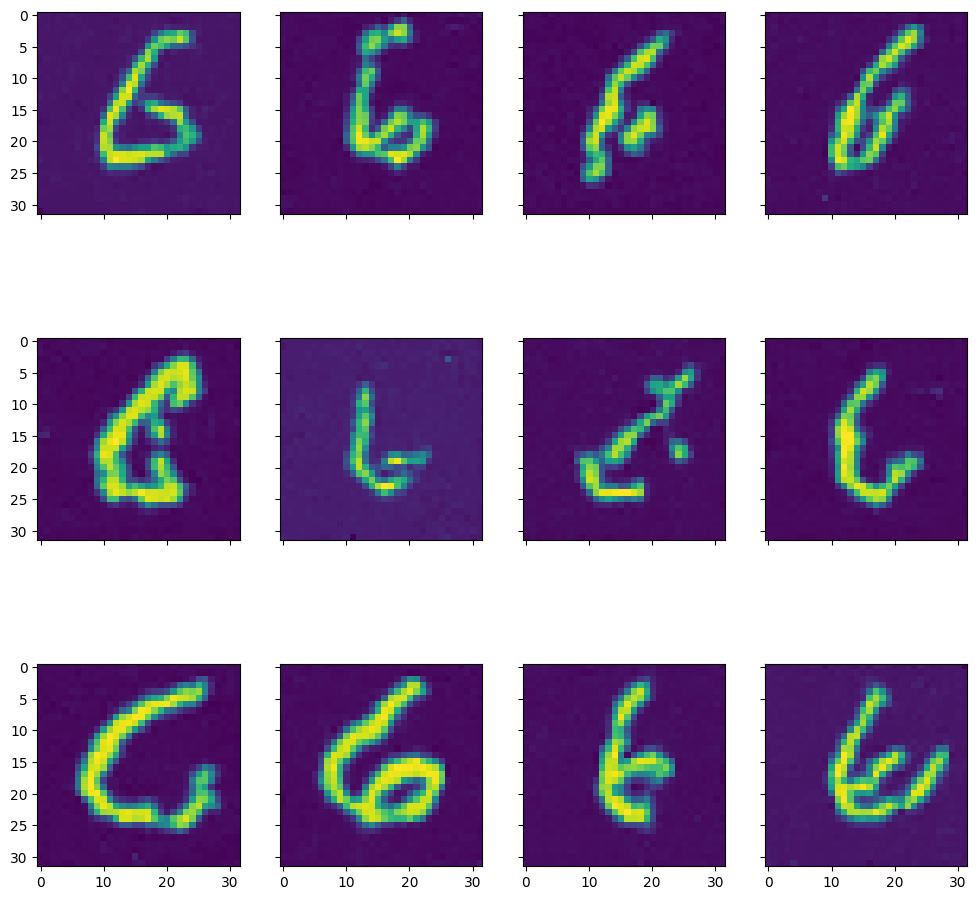

In [27]:
rows = 3
columns = 4
size = (12, 12)
fig, ax = plt.subplots(rows, columns, figsize=(size), sharex=True, sharey=True)

img_init = torch.randn(rows*columns,1,32,32).to(device)
img = rectified_flow_1.sample_ode(img_init, 100)[-1].detach().cpu().numpy()

i = 0
for row in range(rows):
    for column in range(columns):
        ax[row, column].imshow(img[i,0])
        i += 1

plt.show()

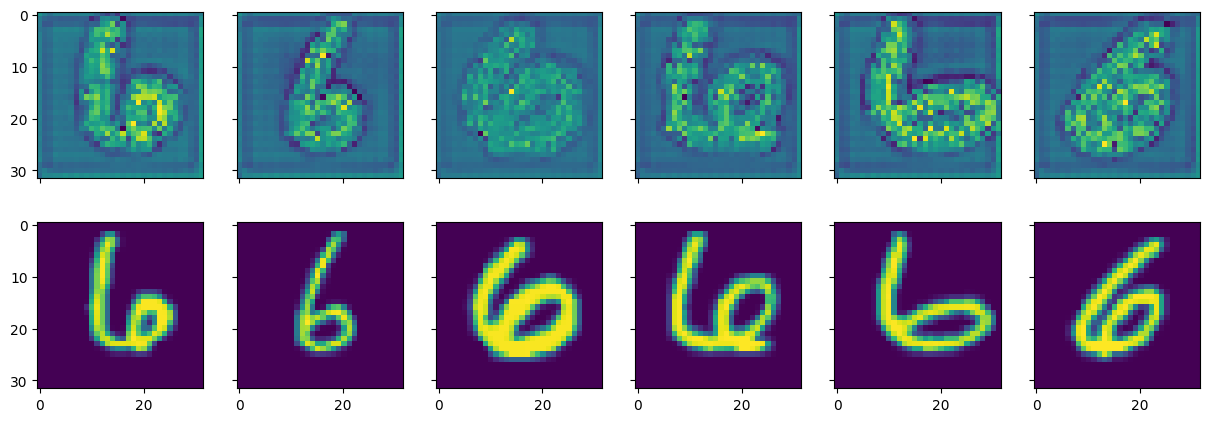

In [28]:
rows = 2
columns = 6
size = (15, 5)
fig, ax = plt.subplots(rows, columns, figsize=(size), sharex=True, sharey=True)


for column in range(columns):
    for batch in train_dataloader:
        batch,_ = batch
        img_init = batch[:10].reshape(10,1,32,32).to(device)
        break

    img = rectified_flow_1.reverse_sample_ode(img_init, 100)[-1][0,0].detach().cpu().numpy()
    ax[0, column].imshow(img)

    ax[1, column].imshow(img_init[0,0].detach().cpu().numpy())

plt.show()

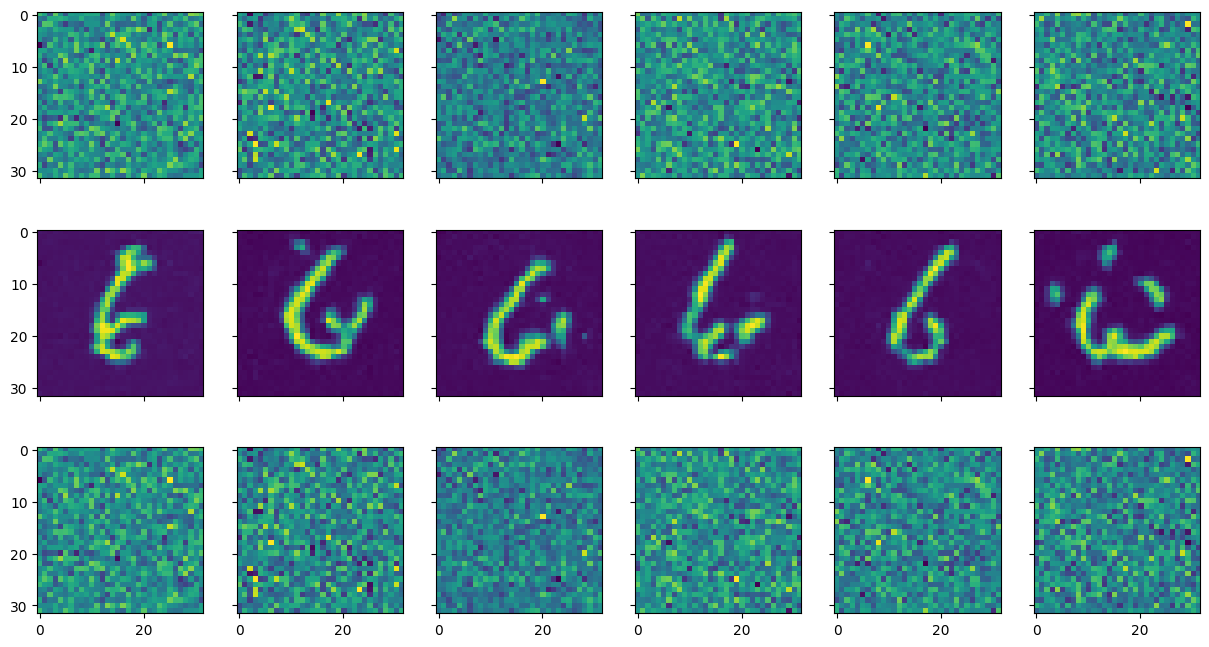

In [29]:
rows = 3
columns = 6
size = (15, 8)
fig, ax = plt.subplots(rows, columns, figsize=(size), sharex=True, sharey=True)


for column in range(columns):
    img_init = torch.randn(1,1,32,32).to(device)
    ax[0, column].imshow(img_init[0,0].detach().cpu().numpy())

    img = rectified_flow_1.sample_ode(img_init, 100)[-1]
    ax[1, column].imshow(img[0,0].detach().cpu().numpy())

    img_rev = rectified_flow_1.reverse_sample_ode(img, 100)[-1]

    ax[2, column].imshow(img_rev[0,0].detach().cpu().numpy())

plt.show()

## Reflow

In [5]:
samples_init = torch.randn(2000,1,32,32).to(device)
flow_1 = rectified_flow_1.sample_ode(samples_init, 100)

In [6]:
v_model_2 = U_Net(input_shape=input_shape, output_channels=1)
rectified_flow_2 = RectifiedFlow_Unet(v_model_2, device)

In [7]:
optimizer_2 = torch.optim.Adam(rectified_flow_2.v_model.parameters(), lr=5e-3)
scheduler_2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_2, factor=0.8, patience=80, verbose=True)

In [8]:
rectified_flow_2 = train_rectified_flow_Unet(rectified_flow_2, optimizer_2, scheduler_2, train_dataloader, device, epochs=40)

Epoch 00485: reducing learning rate of group 0 to 4.0000e-03.
Epoch 00729: reducing learning rate of group 0 to 3.2000e-03.
Epoch 00810: reducing learning rate of group 0 to 2.5600e-03.
Epoch 00891: reducing learning rate of group 0 to 2.0480e-03.


In [7]:
torch.save(rectified_flow_2, "./models/MNIST/MNIST_6_Unet_flow2.pth")

In [6]:
rectified_flow_2 = torch.load("./models/MNIST/MNIST_6_Unet_flow2.pth")

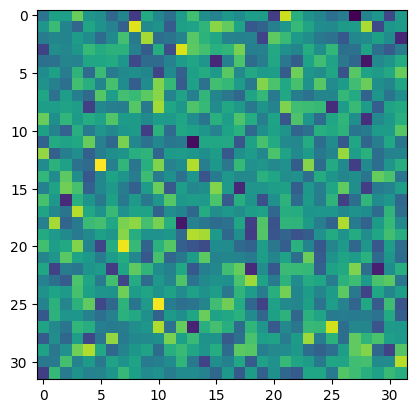

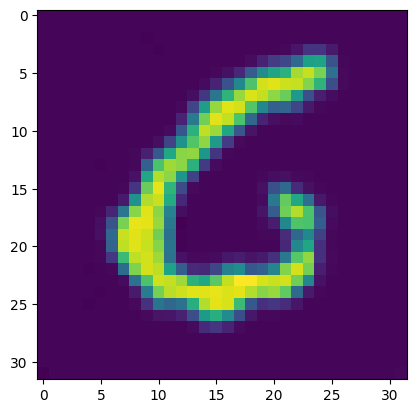

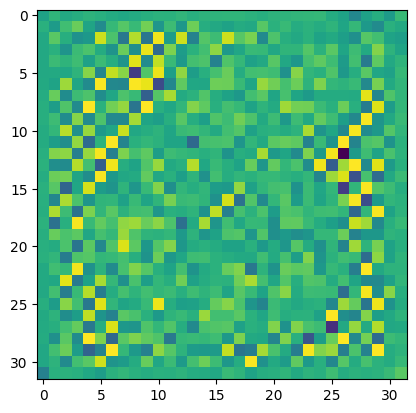

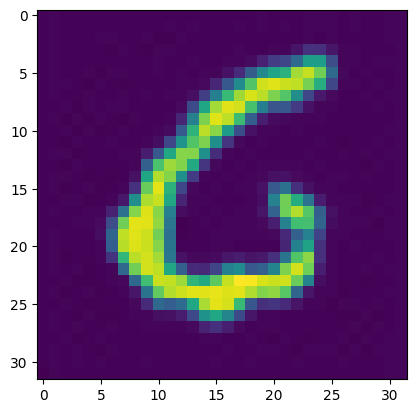

In [15]:
rectified_flow_2.v_model.eval()
img_init = torch.randn(1,1,32,32).to(device)
plt.imshow(img_init[0, 0].detach().cpu().numpy())
plt.show()

img = rectified_flow_2.sample_ode(img_init, 100)[-1]
plt.imshow(img[0, 0].detach().cpu().numpy())
plt.show()
img_r = rectified_flow_2.reverse_sample_ode(img.reshape(1,1,32,32), 100)[-1]
plt.imshow(img_r[0, 0].detach().cpu().numpy())
plt.show()
img2 = rectified_flow_2.sample_ode(img_r, 100)[-1]
plt.imshow(img2[0, 0].detach().cpu().numpy())
plt.show()

[]

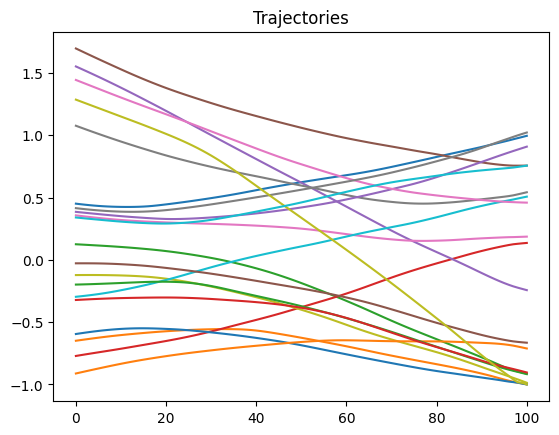

In [19]:
img_init = torch.randn(20,1,32,32).to(device)
img = rectified_flow_2.sample_ode(img_init, 100)
s = torch.zeros(20,len(img),1,32,32)
for i in range(len(img)):
    s[:,i] = img[i]
for i in range(20):
    plt.plot(s[i,:,0,18,13].cpu().numpy())
plt.title("Trajectories")    
plt.plot()

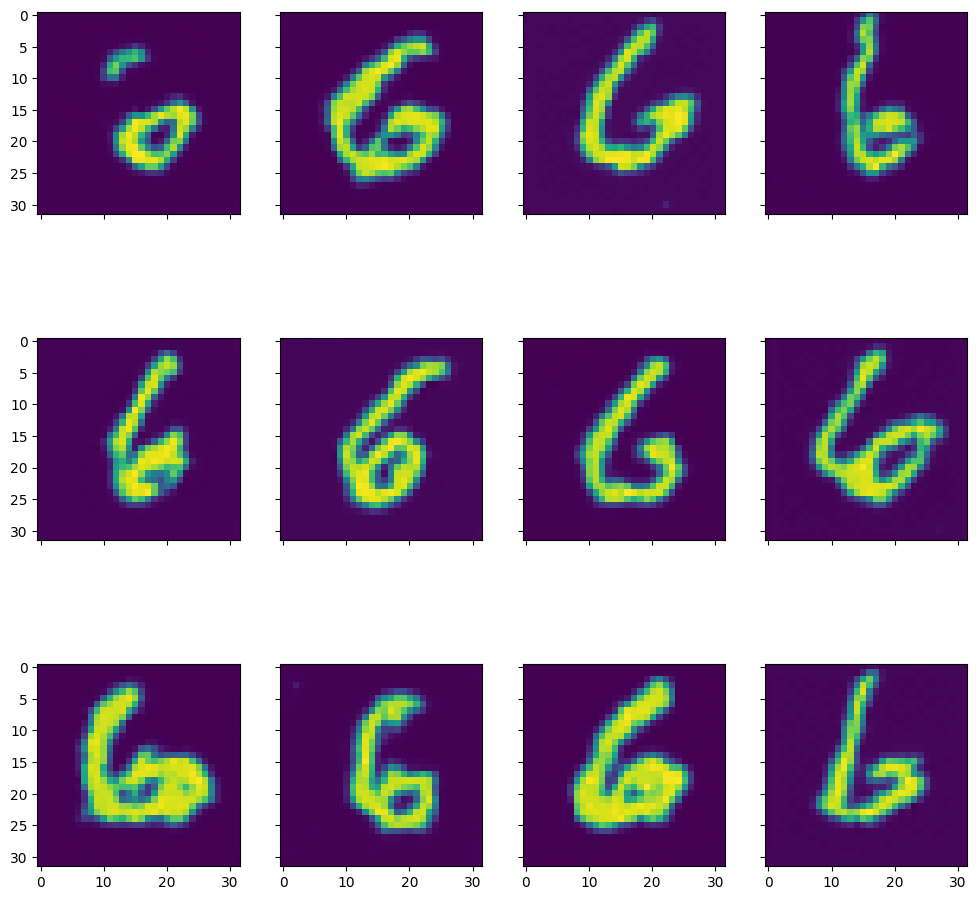

In [20]:
rows = 3
columns = 4
size = (12, 12)
fig, ax = plt.subplots(rows, columns, figsize=(size), sharex=True, sharey=True)

img_init = torch.randn(rows*columns,1,32,32).to(device)
img = rectified_flow_2.sample_ode(img_init, 100)[-1].detach().cpu().numpy()

i = 0
for row in range(rows):
    for column in range(columns):
        ax[row, column].imshow(img[i,0])
        i += 1

plt.show()